In [1]:
from wave_1d_fd_pml import propagators, test_wave_1d_fd_pml, find_profile
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

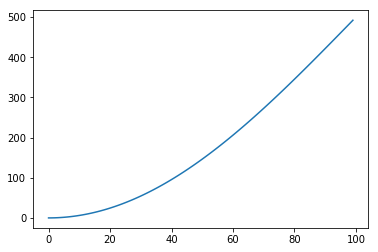

In [2]:
profile=500*(-np.cos(np.arange(0,np.pi/2, np.pi/200))+1).astype(np.float32)
plt.plot(profile)

In [3]:
model = test_wave_1d_fd_pml.model_one(500)
v = propagators.Pml(model['model'], model['dx'], model['dt'], 100, profile=profile)

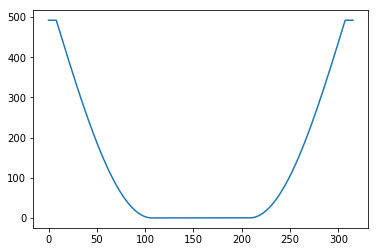

In [4]:
plt.figure();plt.plot(v.sigma)

In [5]:
y = v.steps(model['nsteps'], model['sources'], model['sx'])

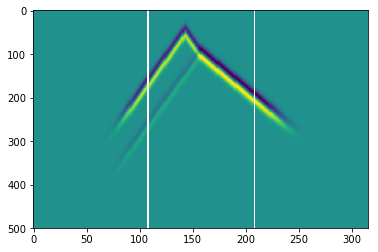

In [6]:
y[:, v.total_pad] = y[:, -v.total_pad] = np.nan
plt.imshow(y[:,:], aspect='auto')

In [7]:
profile=find_profile.find_profile(10, pop_len=5000, ngen=50)

gen	nevals	avg       	std       	min    	max        
0  	5000  	1.9499e+07	2.0456e+08	10.2661	1.20238e+10
1  	2961  	1.58283e+09	7.80898e+10	14.4681	5.08997e+12
2  	3057  	8.2018e+07 	5.66522e+09	6.55004	4.00601e+11
3  	3039  	2.43929e+08	1.21378e+10	4.93979	6.2422e+11 
4  	3105  	5.38523e+10	3.80729e+12	3.87636	2.69243e+14
5  	3033  	3.32059e+06	1.96248e+08	3.26296	1.3831e+10 
6  	3066  	2.36148e+09	1.52452e+11	3.26296	1.07572e+13
7  	3015  	1.35611e+08	7.01782e+09	3.21446	4.81261e+11
8  	2994  	7.98731e+10	5.63059e+12	3.26296	3.98182e+14
9  	2997  	3.36828e+06	1.40737e+08	3.00612	9.21759e+09
10 	2983  	3.1259e+07 	1.42422e+09	2.94288	9.43336e+10
11 	2955  	1.17602e+07	5.23132e+08	2.94288	3.38555e+10
12 	3006  	1.85614e+08	1.28608e+10	2.94288	9.09378e+11
13 	3003  	5.59798e+10	3.95589e+12	2.94288	2.79751e+14
14 	2985  	1.26782e+08	8.71159e+09	2.94288	6.16002e+11
15 	2971  	5.30391e+07	3.54601e+09	2.89216	2.50557e+11
16 	3032  	9.21746e+10	6.17241e+12	2.83129	4.35798e+14
17 	3048  	1.2

In [8]:
profile

[0.06775259469280914,
 0.2650364971070865,
 0.6299571292033623,
 0.9194239794830865,
 0.77794507669468,
 0.49539373613382554,
 0.3857713709442544,
 0.2790358791573351,
 0.15961174729314487,
 0.1839087540013567]

In [9]:
model = test_wave_1d_fd_pml.model_one(500)
v = propagators.Pml(model['model'], model['dx'], model['dt'], 10, profile=1000*np.array(profile))

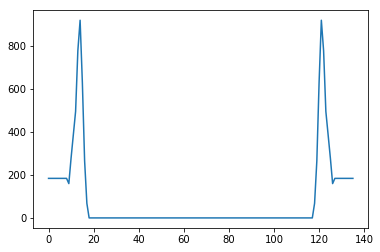

In [10]:
plt.figure();plt.plot(v.sigma)

In [11]:
y = v.steps(model['nsteps'], model['sources'], model['sx'])

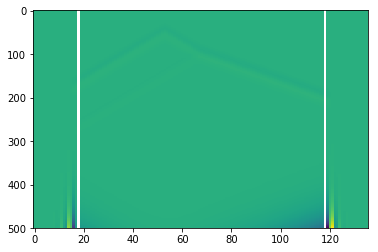

In [12]:
y[:, v.total_pad] = y[:, -v.total_pad] = np.nan
plt.imshow(y[:,:], aspect='auto')

In [ ]:
vs=[1500, 2250, 3000]
freq=25
lambdas=[v/freq for v in vs]
lambda_fracs=[0.25, 0.5, 0.75, 1]
profiles = []
for v, lamb in zip(vs, lambdas):
    for frac in lambda_fracs:
        profile_len = int(np.round(lamb*frac/5)) #dx = 5
        profiles.append(find_profile.find_profile(profile_len, v=v, pop_len=5000, ngen=100, nsteps=500))

In [ ]:
for p in profiles:
    plt.figure()
    plt.plot(p)

In [3]:
model = test_wave_1d_fd_pml.model_one(500)
v = propagators.Pml(model['model'], model['dx'], model['dt'], 10, profile=1000*np.array(profile))

In [6]:
y = v.steps(model['nsteps'], model['sources'], model['sx'])

In [ ]:
y[:, v.total_pad] = y[:, -v.total_pad] = np.nan
plt.imshow(y[:,:], aspect='auto')